In [1]:
import pandas as pd

In [5]:
titanic_df = pd.read_csv("small.csv")
titanic_df.columns

Index(['age', 'portembarked', 'fare', 'numparentschildren', 'passengerclass',
       'sex', 'numsiblings', 'survived'],
      dtype='object')

In [6]:
wine_df = pd.read_csv("medium.csv")
wine_df.columns

Index(['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar',
       'chlorides', 'freesulfurdioxide', 'totalsulfurdioxide', 'density', 'ph',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s }"%(n.label), shape='record')
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)))

    return dot

In [14]:
# Toy example to illustrate the graph library. We can probably make something smarter for our purposes

class Node:
     def __init__(self, prev = [], data=0) -> None:
          self.prev = prev
          self.label = data

In [15]:
root = Node(data='root')
a = Node(data='a', prev=[root])
b = Node(data='b', prev=[root])
c = Node(data='c', prev=[root])

d = Node(data='d', prev=[a, b])
e = Node(data='e', prev=[b, c])

f = Node(data='f', prev=[d,e])

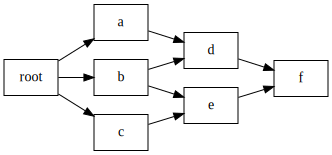

In [17]:
draw_dot(f)